In [1]:
import pandas as pd

In [2]:
df_train = pd.read_csv("Layer08/train.csv")
df_valid = pd.read_csv("Layer08/valid.csv")
df_test = pd.read_csv("Layer08/test.csv")

In [3]:
df_train_X = df_train.copy()
df_train_X.drop(['label_2', 'label_3', 'label_4'], axis=1, inplace=True)
df_train_y = df_train_X.pop('label_1')

df_valid_X = df_valid.copy()
df_valid_X.drop(['label_2', 'label_3', 'label_4'], axis=1, inplace=True)
df_valid_y = df_valid_X.pop('label_1')

df_test_X = df_test.copy()
df_test_X.drop(['ID'], axis=1, inplace=True)

<AxesSubplot:>

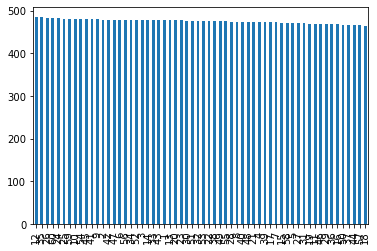

In [4]:
df_train['label_1'].value_counts().plot(kind='bar')

In [5]:
from sklearn.preprocessing import StandardScaler as ss

In [6]:
scaler = ss()
scaler.fit(df_train_X)

StandardScaler()

In [7]:
df_train_X_scaled = scaler.transform(df_train_X)
df_valid_X_scaled = scaler.transform(df_valid_X)
df_test_X_scaled = scaler.transform(df_test_X)

Support Vector Machine

In [8]:
from sklearn.svm import SVC

In [9]:
svc_initial = SVC(kernel="linear")
svc_initial.fit(df_train_X_scaled, df_train_y)

SVC(kernel='linear')

In [10]:
svc_initial.score(df_valid_X_scaled, df_valid_y)

0.94

In [11]:
y_pred_initial_svc = svc_initial.predict(df_valid_X_scaled)

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [13]:
acs_initial = accuracy_score(df_valid_y, y_pred_initial_svc)
pcs_initial = precision_score(df_valid_y, y_pred_initial_svc, average='weighted')
rcs_initial = recall_score(df_valid_y, y_pred_initial_svc, average='weighted')
print(f"Accuracy score before SVC: {acs_initial:.4f}")
print(f"Precision score before SVC: {pcs_initial:.4f}")
print(f"Recall score before SVC: {rcs_initial:.4f}")

Accuracy score before SVC: 0.9400
Precision score before SVC: 0.9456
Recall score before SVC: 0.9400


PCA

In [14]:
from sklearn.decomposition import PCA

In [15]:
pca = PCA(0.99)
pca.fit(df_train_X_scaled)

pca_df_train_X = pca.transform(df_train_X_scaled)
pca_df_valid_X = pca.transform(df_valid_X_scaled)
pca_df_test_X = pca.transform(df_test_X_scaled)

In [16]:
pca_df_train_X.shape

(28520, 572)

Hyperparameter Tuning

In [17]:
from sklearn.model_selection import RandomizedSearchCV as rscv

In [18]:
from scipy.stats import uniform, randint

In [19]:
from functools import partial

In [20]:
# param_dist = {
#     'C': [0.1, 10],
#     'gamma': [0.001, 1],
#     'kernel': ['linear'],
#     'degree': [1, 2]
# }

param_dist = {
    'C':[0.1, 1, 10],
    'kernel': ['linear'],
    'degree': [2, 3, 4],
    'gamma': [0.001, 0.1, 1.0]
}

In [21]:
svc_tuning = SVC()
random_search = rscv(
    svc_tuning, 
    param_distributions=param_dist,
    n_iter=3, cv=5, n_jobs=-1, verbose=1)

random_search.fit(df_train_X_scaled, df_train_y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_iter=3, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10], 'degree': [2, 3, 4],
                                        'gamma': [0.001, 0.1, 1.0],
                                        'kernel': ['linear']},
                   verbose=1)

In [22]:
best_params = random_search.best_params_
best_score = random_search.best_score_
print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)

Best Hyperparameters: {'kernel': 'linear', 'gamma': 1.0, 'degree': 2, 'C': 0.1}
Best Score: 0.9260168302945303


In [23]:
svc_after_tuning = SVC(**best_params)
svc_after_tuning.fit(df_train_X_scaled, df_train_y)

SVC(C=0.1, degree=2, gamma=1.0, kernel='linear')

In [24]:
y_pred_after_tuning = svc_after_tuning.predict(df_valid_X_scaled)

In [25]:
acs_after_tuning = accuracy_score(df_valid_y, y_pred_after_tuning)
pcs_after_tuning = precision_score(df_valid_y, y_pred_after_tuning, average='weighted')
rcs_after_tuning = recall_score(df_valid_y, y_pred_after_tuning, average='weighted')
print(f"Accuracy score after: {acs_after_tuning:.4f}")
print(f"Precision score after: {pcs_after_tuning:.4f}")
print(f"Recall score after: {rcs_after_tuning:.4f}")

Accuracy score after: 0.9453
Precision score after: 0.9504
Recall score after: 0.9453


CSV

In [54]:
import csv

In [55]:
IDs = [i+1 for i in range(len(y_pred_after_tuning))]

In [58]:
Data = {
    'ID': IDs,
    'label_1': y_pred_after_tuning 
}

In [60]:
data_frame = pd.DataFrame(Data)
data_frame.head

<bound method NDFrame.head of       ID  label_1
0      1       26
1      2       18
2      3       16
3      4        7
4      5       58
..   ...      ...
739  740       35
740  741       35
741  742       54
742  743       38
743  744       51

[744 rows x 2 columns]>

In [57]:
csv_file = 'Layer08_Label01.csv'
data_frame.to_csv(csv_file, index=False)